## Recover temporal latent causal factors with simulated data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import ltcl
from ltcl.modules.flow import TemporalMBDFlow
from ltcl.datasets.sim_dataset import SimulationDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [4]:
train_dataset = SimulationDataset("train")
training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = SimulationDataset("val")
validation_generator = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

In [5]:
flow = TemporalMBDFlow(input_size = 4, 
                       lags = 2,
                       batch_norm = True)
flow = flow.to(device)

In [6]:
max_epochs = 50
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

In [ ]:
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    running_loss = 0
    for batch_sample in training_generator:
        batch_x = batch_sample["x"]
        batch_y = batch_sample["y"]
        # Transfer to GPU
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        # Model computations
        loss = -flow.log_prob(batch_x, batch_y)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.item()
    print(f"Training loss: {running_loss/len(training_generator)}")
    # Validation
    running_loss = 0
    with torch.set_grad_enabled(False):
        for batch_sample in validation_generator:
            # Transfer to GPU
            batch_x = batch_sample["x"]
            batch_y = batch_sample["y"]
            # Transfer to GPU
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            loss = -flow.log_prob(batch_x, batch_y)
            running_loss += loss.item()
        print(f"Validation loss: {running_loss/len(validation_generator)}")

Training loss: 393.34919368743897
Validation loss: 303.5143927001953
Training loss: 270.5941298294067
Validation loss: 246.45341918945311
Training loss: 231.0352024269104
Validation loss: 218.02449508666993
Training loss: 207.96979433059693
Validation loss: 199.23587158203125
Training loss: 192.35879123687744
Validation loss: 185.84836608886718
Training loss: 180.66976961135865
Validation loss: 176.4892463684082
Training loss: 172.94272045135497
Validation loss: 170.0023193359375
Training loss: 167.5153451347351
Validation loss: 165.46531127929688
Training loss: 163.64119565963745
Validation loss: 162.0346974182129
Training loss: 160.58372621536256
Validation loss: 159.1711050415039
Training loss: 157.90465576171874
Validation loss: 156.63544967651367
Training loss: 155.52118217468262
Validation loss: 154.36278564453124
Training loss: 153.2791868019104
Validation loss: 152.08884490966796
Training loss: 150.86460916519164
Validation loss: 149.44840026855468
Training loss: 148.2218037414

In [34]:
y = torch.rand(16, 4, 2).cuda()

In [39]:
import numpy as np

In [146]:
d = np.load("/home/cmu_wyao/projects/data/499.npz")

In [147]:
d["x"].shape

(128, 80, 4)

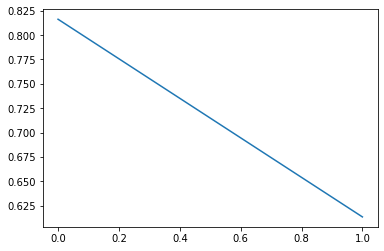

In [150]:
plt.plot(d["y"][2,:,1])

In [ ]:
torch.uni

In [ ]:
torch.bmm

In [37]:
flow.sample(y, 128)

RuntimeError: The size of tensor a (128) must match the size of tensor b (16) at non-singleton dimension 0

In [14]:
x = torch.rand(16, 8, 2)
y = torch.rand(16, 4, 2)

In [19]:
flow.log_prob(x, y)

tensor(-98.6351, grad_fn=<MeanBackward0>)

In [10]:
sum_log_abs_det_jacobians

tensor([13.7777,  8.7662, 12.9915,  3.5598,  6.7196,  5.2455,  5.3330,  9.8531,
         7.6980,  6.1647,  8.2872, 11.3447,  8.8890, 11.8513, 11.4018, 10.5304],
       grad_fn=<AddBackward0>)

In [6]:
e.shape, z.shape, sum_log_abs_det_jacobians.shape

(torch.Size([16, 8, 2]), torch.Size([16, 8, 2]), torch.Size([16]))

In [7]:
xx = flow.inverse(z, y)

In [10]:
sum_log_abs_det_jacobians

tensor([ -3.9754,   1.4525, -11.8307,   4.9286,  -7.9111,  -6.1972,   2.7244,
        -12.6433,  -8.9205,  -2.1613,  -2.2704,  -4.0597,   1.5329,  -0.9711,
         -3.9992,  -6.1606], grad_fn=<AddBackward0>)